# Action-independend Heuristic Dynamic Programming, Model-based
#### Import dependencies & Custom classes

In [2]:
# General imports
import numpy as np
import pandas as pd
import gym
import os
import datetime
from tqdm import tqdm

# Plot library
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [24, 4]
%matplotlib inline

# Custom classes
%cd pathlib.Path().resolve().parents[2]
%load_ext autoreload
import envs.shortperiod
from utils.pid import PID


[WinError 2] Het systeem kan het opgegeven bestand niet vinden: 'pathlib.Path().resolve().parents[2]'
C:\Users\Dave\OneDrive\Documenten\TU Delft\AE5310 Thesis Control and Operations\04_Code\msc-thesis\code\PID
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'envs'

#### Flags & Simulation Parameters and Data Storage

In [2]:
%autoreload

# Flags
LOG = True
SAVE = True

# Locations
TENSORBOARD_DIR = './logs/tensorboard/'
CHECKPOINT_DIR = './logs/checkpoint/'

# Simulation parameters
env = gym.make('ShortPeriod-v0')
dt, env.dt = 2*(1/100,)         # [s] - Time step
T = 120.                        # [s] - Episode Length
t = np.arange(0, T, dt)         # [s] - Time vector
time_steps = len(t)             # [-] - Number of timesteps

pid_controller = PID(Kp = -12.0, Ki = -1.0, Kd = 0.0, dt = dt)

# Data storage
data = pd.DataFrame({
    'State': [np.zeros(2)]*time_steps, 
    'Action': [0.]*time_steps, 
    'Cost': [0.]*time_steps, 
    'Next State':[np.zeros(2)]*time_steps,
    'Reference Pitch Rate': [0.]*time_steps,
    'Error': [0.]*time_steps
    })

# Prepare training
reference_signal = 10./180.*np.pi*np.sin(1/10*np.pi*t) #ReferenceSignalGenerator('sine', amplitude = 0.15, speed = 1.0, offset = 0.0)

#### Run training

In [3]:
%autoreload

# Set run time
run_time = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# Initialize lists
state, action, cost, error = ([] for i in range(4))

# Reset environment
state.append(env.reset())
u = np.zeros(1)
for i in tqdm(range(len(t))):
    
    # Sample reference signal and create augmented state
    ref_q = reference_signal[i]
    error.append(ref_q - state[i][2])

    # Run environment
    u = pid_controller(error[i])
    action.append(u)
    X, R, _, _ = env.step(action[i], ref_q)
    state.append(X)
    cost.append(R)
    
# Save data to Pandas.DataFrame
data['State'] = state[:-1]
data['Action'] = action
data['Cost'] = cost
data['Next State'] = state[1:]
data['Reference Pitch Rate'] = reference_signal
data['Error'] = error

if SAVE:
    data.to_pickle('./logs/data/dataframe_pid_'+ run_time +'.pkl')

    db_csv = pd.DataFrame(columns=['alpha', 'theta', 'q', 'q_ref', 'action', 'cost'])
    db_csv['alpha'] = np.vstack(data['State'].values)[:,0]
    db_csv['theta'] = np.vstack(data['State'].values)[:,1]
    db_csv['q'] = np.vstack(data['State'].values)[:,2]
    db_csv['q_ref'] = data['Reference Pitch Rate']
    db_csv['action'] = np.vstack(data['Action'])
    db_csv['cost'] = data['Cost']
    db_csv.to_csv('./logs/data/csv/dataframe_pid_'+ run_time +'.csv')  


100%|██████████| 12000/12000 [00:00<00:00, 68500.43it/s]


## Visualizations
#### Action

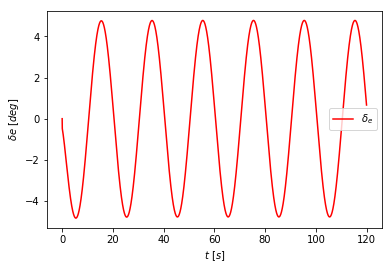

In [212]:
# Plot action
u = data['Action'].values

plt.plot(t, u/np.pi*180., 'r-', label=r'$\delta_{e}$')  
plt.xlabel(r'$t\ [s]$')
plt.ylabel(r'$\delta{e}\ [deg]$')
plt.legend()
if SAVE and os.getcwd() == '/home/dave992/JupyterServer/ms-thesis':
    if not os.path.exists('./logs/figures/hdp_' + run_time + '/'):
        os.makedirs('./logs/figures/hdp_' + run_time + '/')
    if not os.path.isfile('./logs/figures/hdp_' + run_time + '/elevator.png'):
        plt.savefig('./logs/figures/hdp_' + run_time + '/elevator.png')
plt.show()

#### Pitch rate (and reference)

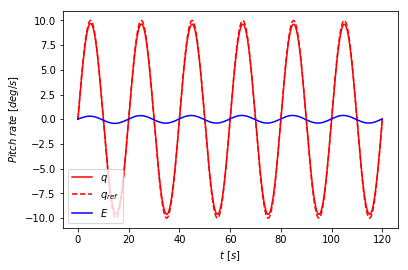

In [213]:
# Plot pitch rate and reference
state = np.vstack(data['State'].values)
error = data['Error'].values



plt.plot(t, 180/np.pi*state[:,2], 'r-', label=r'$q$')  
plt.plot(t, 180/np.pi*reference_signal, 'r--', label=r'$q_{ref}$')  
plt.plot(t, 180/np.pi*error, 'b-', label=r'$E$')  
plt.xlabel(r'$t\ [s]$')
plt.ylabel(r'$Pitch\ rate\ [deg/s]$')
plt.legend()

plt.show()

#### Current Cost

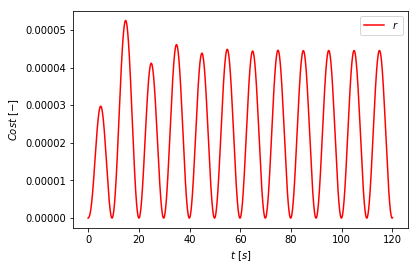

In [214]:
cost = data['Cost'].values

plt.plot(t, cost, 'r-', label=r'$r$')  
plt.xlabel(r'$t\ [s]$')
plt.ylabel(r'$Cost\ [-]$')
plt.legend()


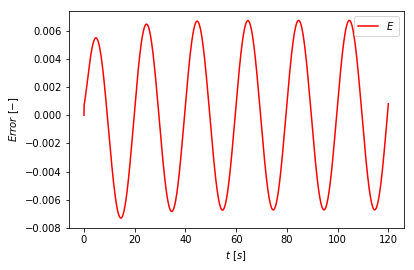

In [215]:
error = data['Error'].values

plt.plot(t, error, 'r-', label=r'$E$')  
plt.xlabel(r'$t\ [s]$')
plt.ylabel(r'$Error\ [-]$')
plt.legend()


In [8]:
def avg_error(deg):
    rad = deg*np.pi/180
    return 120*100*(rad**2)
    

In [20]:
y = 7.4
print(avg_error(y))

200.1701988902419


#### Legacy code

In [12]:
0.0003046174190905562*100*120

3.655409029086674

In [11]:
%autoreload

# Flags
LOG = True
LOAD = False
SAVE = True
REPEAT_UPDATE = True
RENDER = False                # Not working with tqdm progres bar

# Locations
TENSORBOARD_DIR = './logs/tensorboard/'
CHECKPOINT_DIR = './logs/checkpoint/'

# Simulation parameters
env = gym.make('ShortPeriod-v0')
dt, env.dt = 2*(1/100,)       # [s] - Time step
T = 50.                         # [s] - Episode Length
t = np.arange(0, T, dt)         # [s] - Time vector
time_steps = len(t)             # [-] - Number of timesteps

# HDP parameters
n_repeat_update = 5     # [-] - Number of repeated updates (if REPEAT_UPDATE, else 1)

if LOAD:
    # Load existing network from checkpoint
    agent = HDP.Agent(env, load = '')
else:
    # Define network hyperparameters
    kwargs = {
        'input_size': 1,
        'output_size': 1,
        'hidden_layer_size': [6],
        'lr_critic': 0.001,
        'lr_actor': 0.0001,
        'gamma': 0.8,
        'activation': tf.nn.tanh,
        'log_dir': TENSORBOARD_DIR,
        'session_config': tf.ConfigProto(device_count = {'GPU': 0}) # Run on CPU
    }
    agent = HDP.Agent(env, **kwargs)

# Data storage
data = pd.DataFrame({
    'State': [np.zeros(agent.input_size)]*time_steps, 
    'Action': [0.]*time_steps, 
    'Cost': [0.]*time_steps, 
    'Next State':[np.zeros(agent.input_size)]*time_steps,
    'Augmented State': [np.zeros(agent.input_size)]*time_steps,
    'Reference Pitch Rate': [0.]*time_steps
    })

# Prepare training
cycles = n_repeat_update if REPEAT_UPDATE else 1
reference_signal = 10./180.*np.pi*np.sin(1/10*np.pi*t) #ReferenceSignalGenerator('sine', amplitude = 0.15, speed = 1.0, offset = 0.0)
dxdu = np.array([env.B[2]])*dt

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Critic Network build.
Actor network build.


In [12]:
%autoreload
   
# Initialize lists
state, action, cost, augmented_state = ([] for i in range(4))

# Initialize TensorBoard logging
if LOG:
    run_time = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    agent.create_tensorboard_writer(TENSORBOARD_DIR + 'tb_hdp_' + run_time)

# Reset environment
state.append(env.reset())
for i in tqdm(range(len(t))):
    
    # Sample reference signal and create augmented state
    ref_q = reference_signal[i]
    augmented_state.append(augment_hdp_state(state[i], ref_q))

    # Run environment
    action.append(agent.action(augmented_state[i]))
    X, R, _, _ = env.step(action[i], ref_q)
    state.append(X)
    cost.append(R)
    
    # Visualize environment
    if RENDER:
        env.render()
            
    # Calculate target for critic
    value_target = cost[i-1] + agent.gamma*agent.value(augmented_state[i])

    # Run update cycles, critic then actor
    for j in range(cycles):
        # Update critic
        agent.update_critic(np.array([augmented_state[i-1]]), value_target)
            
        # Update Actor
        agent.update_actor(augmented_state[i], dxdu = dxdu)
        
    # Log training data using TensorBoard
    if LOG:
        agent.writer.add_summary(agent.summary(augmented_state[i], value_target), i)

    # Save network every 5% of the training phase
    if SAVE and i % int(.05*time_steps) == 0:
        agent.save(file = CHECKPOINT_DIR + 'hdp_cp_' + run_time + '/ckpt', global_step = i)

# Save data to Pandas.DataFrame
data['State'] = state[:-1]
data['Action'] = action
data['Cost'] = cost
data['Next State'] = state[1:]
data['Augmented State'] = augmented_state
data['Reference Pitch Rate'] = reference_signal
if SAVE:
    data.to_pickle('./logs/data/dataframe_hdp_'+ run_time +'.pkl')

100%|██████████| 5000/5000 [00:30<00:00, 161.78it/s]


FileNotFoundError: [Errno 2] No such file or directory: './data/dataframe_hdp_2018-08-21_21-55-20.pkl'

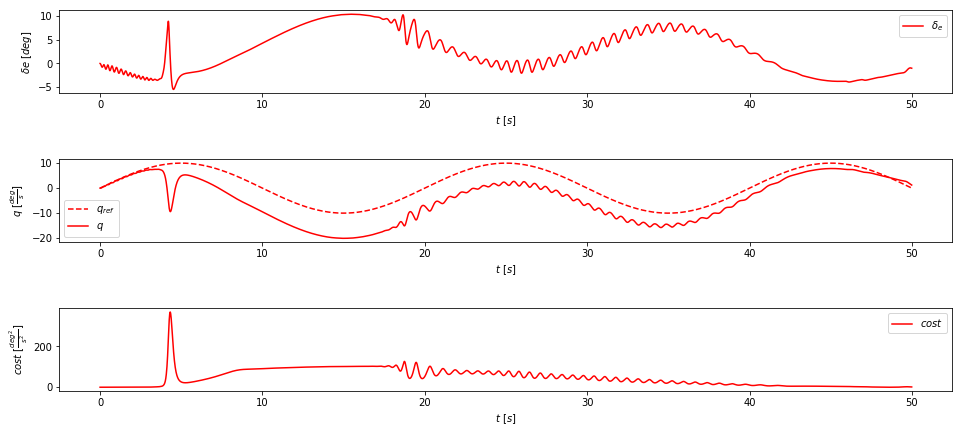

In [16]:
# generate plot
q_ref = np.array([_ for _ in reference_signal])
q     = np.array([_[2] for _ in state[0:-1]])
        
# plot control input
plt.rcParams['figure.figsize'] = [16, 7]
ax = plt.subplot(3,1,1)
plt.plot(t, np.array(action).flatten()/np.pi*180., 'r-', label=r'$\delta_{e}$')   
plt.xlabel(r'$t\ [s]$')
plt.ylabel(r'$\delta{e}\ [deg]$')
plt.legend()

# plot reference signal
plt.subplot(3,1,2,sharex=ax)
plt.plot(t, q_ref*180./np.pi, 'r--', label=r'$q_{ref}$')
plt.plot(t, q*180./np.pi, 'r-', label=r'$q$')
plt.xlabel(r'$t\ [s]$')
plt.ylabel(r'$q\ [\frac{deg}{s}]$')
plt.legend()

# plot cost history
plt.subplot(3,1,3,sharex=ax)
plt.plot(t, np.array(cost)*(180./np.pi)**2, 'r-', label=r'$cost$')   
plt.xlabel(r'$t\ [s]$')
plt.ylabel(r'$cost\ [\frac{deg^{2}}{s^{2}}]$')
plt.subplots_adjust(hspace=.8)
plt.legend()
plt.show()